In [1]:
import numpy as np
import scipy.signal as sig
import scipy.io
import os
import librosa
import sys
from IPython.display import display, Audio


import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', size=10)
plt.rc('font', family='serif')
plt.rc('lines', linewidth = .5)
cm = 2.54
# setting path
sys.path.append("../")
from Utils.dB import *
from HN_decomposition.Subspace.preprocessing import *
from HN_decomposition.Subspace.ESPRIT import *

def RMS(x):
        return np.std(x)

figsize = (8.5/cm, 6/cm)

def normalize(input_array, value = 1):
        return input_array/np.amax(np.abs(input_array))*value

### Creating a basic modulated sine-wave

In [2]:
sr_hz = 22050
t = np.arange(2*sr_hz)
baseFreq = 440/sr_hz #Hz
modFreq = 1/sr_hz #Hz
modAmp = 100/sr_hz #Hz
sineAmp = 1
noiseAmp = .1

full_phase = baseFreq*t + modAmp/(2*np.pi*modFreq)*np.cos(2*np.pi*modFreq*t)
full_phase *= 2*np.pi
#x = sineAmp*np.sin(full_phase)
#x += noiseAmp*np.random.randn(np.shape(t)[0])


## Loading the audio file

In [3]:
fileName = os.path.join('..', 'Data', 'Test', '69.wav')
x, sr_hz = librosa.load(fileName)
x = x[:2*sr_hz]



In [4]:
save_folder = os.path.join("..", "..", "PAM_overleaf", "Notes", "HR", "preprocessing", "Figures")

## Sub-band decomposition

(44100,)


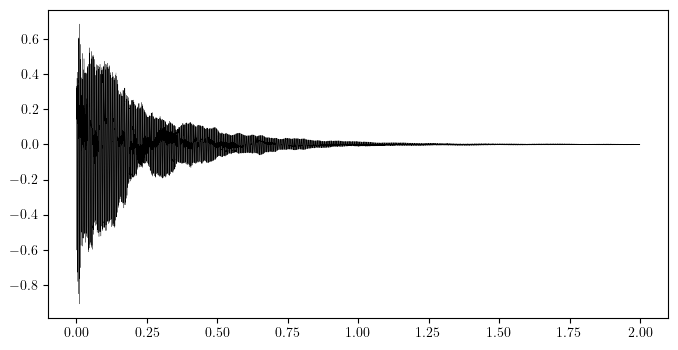

In [5]:

def filter_n_decimate(filterLength_smp : int, numBands : int, inputSignal : np.array):
    """
    args :
        - filterLength : [int]
            Digital filter length, in samples
        - numBands : [int]
            Number of frequency channels in which the signal is to be separated
        - inputSignal : [(1, N) np.array]
            Input signal 
    returns :
        - outputSignals : [(numBands, N) np.array]
            Output signal"""
    signalLength_smp = np.shape(inputSignal)[0] #Input signal length
    filteredSignal = np.zeros((signalLength_smp, numBands)) #initializing the output signal
    
    #h = scipy.signal.remez(numtaps = filterLength_smp, bands = [0, 1/(2*numBands), 1/(2*numBands), .5], fs = 1)

    for i in range(numBands):
        filteredSignal[:,i] = inputSignal

    filters = np.zeros((filterLength_smp, numBands))

    n = np.arange(filterLength_smp)
    base_filter = np.zeros(filterLength_smp)
    for i in range(filters):
        filters[i] = base_filter
    
    outputSignal = filteredSignal[::numBands]
    return outputSignal



print(np.shape(x))
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(x))/sr_hz, x, 'k', linewidth = .2)
plt.show()

## Whitening the noise

In [6]:
rankFilter_bins = 21
rankFilter_rank = .3

n_fft = 512
hop_length = n_fft

In [7]:

print(np.shape(x))
x_stft = librosa.stft(x ,n_fft = n_fft, hop_length = hop_length, center=False)

xRankFiltered_stft = rankFilter_stft(x_stft, rankFilter_bins = rankFilter_bins, rankFilter_rank = rankFilter_rank)

window_type = 'hann'
xWhitened, xChopped, ARFilters = whiten_signal(
    x = x,
    n_fft = n_fft,
    hop_length = hop_length,
    rankFilter_bins = rankFilter_bins,
    rankFilter_rank = rankFilter_rank,
    ARFilter_length = 12,
    window_type=window_type)
xWhitened_stft = compute_stft_from_whitened(xWhitened, window_type=window_type)

t_list = librosa.frames_to_samples(np.arange(np.shape(x_stft)[1]), n_fft = n_fft, hop_length=hop_length)/sr_hz
f_list = librosa.fft_frequencies(sr = sr_hz, n_fft = n_fft)

print(f'sample rate : {sr_hz}')

time_frame_display = 11


(44100,)
sample rate : 22050


## Base ESPRIT

In [8]:
num_poles = 32

plt.figure(figsize = figsize, dpi = dpi)
plt.pcolormesh(t_list, f_list, dB20(x_stft), cmap = cmap, vmax = 20, vmin = -100, rasterized=True)

xHarmoChopped = np.zeros(np.shape(xChopped))
xHarmo = np.zeros(np.shape(x))

for timeFrame in range(np.shape(xWhitened)[1]):
    poles, complexAmp, Lambda = ESPRIT(xWhitened[:,timeFrame], num_poles = num_poles)
    freqs = np.sort(sr_hz/(2*np.pi)*np.angle(poles))[num_poles//2:]
    plt.plot(np.ones(num_poles//2)*t_list[timeFrame], freqs, 'r.', markersize = 1)
    for i, pole in enumerate(poles):
        xHarmoChopped[:,timeFrame] += np.real(np.power(pole*np.ones(np.shape(xHarmoChopped)[0]), np.arange(np.shape(xHarmoChopped)[0]))*complexAmp[i])
    xHarmoChopped[:,timeFrame] = sig.lfilter([1], ARFilters[:,timeFrame], xHarmoChopped[:,timeFrame])
    xHarmo[hop_length*timeFrame:hop_length*timeFrame+n_fft] += xHarmoChopped[:,timeFrame]
    
display(Audio(x, rate = sr_hz))
display(Audio(xHarmo, rate = sr_hz))
display(Audio(x-xHarmo, rate = sr_hz))

scipy.io.wavfile.write(os.path.join('HN/Preprocessing/Audio', 'input.wav'), rate =sr_hz, data = normalize(x))
scipy.io.wavfile.write(os.path.join('HN/Preprocessing/Audio', 'harmo.wav'), rate =sr_hz, data = normalize(xHarmo))
scipy.io.wavfile.write(os.path.join('HN/Preprocessing/Audio', 'noise.wav'), rate =sr_hz, data = normalize(x-xHarmo))

plt.xlabel("$t$ [s]")
plt.ylabel("$f$ [Hz]")
plt.colorbar(label = '$|X|^2$')
plt.tight_layout()
plt.savefig(fname = os.path.join(save_folder, "ESPRIT_stft.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
plt.show()
plt.close()




NameError: name 'dpi' is not defined

## Adaptative ESPRIT

In [ ]:

def ESPRIT_adaptive(xChopped:npt.ArrayLike,num_poles:int, beta:float = 1):
    """
    Performs the ESPRIT algorithm over the input signal based on [1]

   
    args :
        - x : array-like
            input signal
        - signalSpace_dim : int
            dimension of the signal space 
        - beta : float
            forgetting factor
    returns:
        - delta : array-like
            dampening factors
        - f

    References :
    [1] R. Badeau, B. David, and G. Richard, 'Fast Approximated Power Iteration Subspace Tracking,' IEEE Trans. Signal Processing, vol. 53, no. 8, Aug. 2005.

    """

    # Getting the number of samples in each window and the number of samples
    window_size, num_windows = np.shape(xChopped)
    J = np.array([
        [1, 0],
        [0, -np.power(beta, window_size)]
    ])

    #Initializing output arrays
    poles_list = np.zeros(num_poles, num_windows)
    complexAmp_list = np.zeros(num_poles, num_windows)
    correlation_matrix_size = window_size//2
    exp_window = np.power(beta, np.arange(num_windows)+1-num_windows)[:,None]

    # Initializing
    W = np.concatenate((np.eye(num_poles),np.zeros((correlation_matrix_size, num_poles))), axis = 0)
    Z = np.eye(num_poles)
    X = np.zeros(correlation_matrix_size, window_size)
    Vhat = np.zeros(num_poles, window_size)

    for window_idx in range(num_windows):
        #Input vector
        x = (xChopped[:,window_idx]*exp_window)

        x_tl = X[:,0]
        X = np.concatenate((X[:,1:],x), axis=1)

        y = (W.H)@X

        vhat_tl = Vhat[:,0]
        Yhat = np.concatenate((Vhat[:,1:], y), axis=1)

        v_tl = (W.H)@x_tl

        xline = np.concatenate((x, x_tl), axis=1)

        ylinehat = np.concatenate((y, vhat_tl), axis=1)

        yline = np.concatenate((y, v), axis=1)

        hline = Z@ylinehat

        gline = hline@np.linalg.inv(beta*np.linalg.inv(J) + (y.H)@hline)

        ## TW - API main section

        eline = xline - W@y

        Theta  = np.sqrt(np.eye(num_poles) + gline@((eline.H)@eline)@(gline.H))

        Z = (Theta.H)@(np.eye(num_poles) - gline@(yline.H))@Z@(Theta.H)

        W = (W + eline@(gline.H))@Theta

        Vhat = (Theta.H)@Yhat



In [15]:
np.power(2, np.array([1,2,3]))

array([2, 4, 8], dtype=int32)